In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
#using tensorfow backend

Using TensorFlow backend.


In [3]:
#ok funciona bien
#funcion que hace reshape de las imagenes
#sin agregar el bias
def reshapeImages(x,y):
    im_shape = x.shape[1:]
    x = np.reshape(x,(x.shape[0],np.prod(im_shape)))
    return x,y

In [4]:
#ok funciona bien
#crea una matriz random pasandosele las dimensiones
#hay que tener en cuenta el bias afuera
#solo recibe las dimensiones y devuelve matriz de d1 x d2
def createRandomMatrix(d1,d2):
    W = np.random.rand(d1,d2) * 1e-4 #coeficientes en un rango [0,1e-3)
    return W

In [5]:
#ok funciona bien
#randomiza filas de una matriz
#es para shufflear las imagenes antes de tomar los batchs
def randomizeMatrixRows(x,y):
    #x matriz de imagenes (imagenes x dimension)
    #y matriz de scores verdaderos (imagenes x categorias)
    indices = np.random.choice(x.shape[0], x.shape[0], replace=False)
    x = x[indices]
    y = y[indices]
    return x,y

In [6]:
#ok funciona bien
#adds una columna de 1's al comienzo de x
#donde x va a ser la matriz de las imagenes (imagenes x 3072)
#retorna (imagenes x 3073) donde la primera columna es de 1's
def addBias(x):
    aux = np.ones((x.shape[0],1))
    x = np.hstack((aux,x))
    return x

In [7]:
#accuracy metrica
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
def accuracy(scores,y):
    y_pred = np.argmax(scores,axis=1) #selecciona categoria correcta
    y_true = np.argmax(y,axis=1) #selecciona categoria correcta
    acc = np.mean(y_pred == y_true) #calculo accuracy
    return acc

In [8]:
#metrica MSE // mean square error
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
def MSE(scores,y):
    mse = np.mean(np.sum((scores-y)**2,axis=1))
    return mse

In [9]:
#gradiente metrica MSE
def grad_MSE(scores,y):
    gradmse = (scores-y)*2
    return gradmse

In [10]:
#loss function para softmax
#le paso los scores de todas las imagenes (imagenes x categorias)
#y la matriz y formato tipo (imagenes x categorias)
#idem argumentos que MSE
def loss_softmax(scores,y):
    #estabilidad numerica como haciamos en softmax 
    #basicamente lo de la practica anterior, cambio un poco los nombres para que me quede mas claro
    scoresmax = scores.max(axis=1) #maximo de cada fila
    scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
    y = np.argmax(y,axis=1)
    scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
    expscores = np.exp(scores) #hace exp(scores)
    sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
    loss = np.log(sum_expscores) - scores_yi #aca estan las loss_i en vector fila
    loss = loss.mean() #vector fila, solo hago el mean, no sobre algun axis particular
    return loss

In [11]:
#gradiente para softmax
#idem practica anterior, cambio los nombres para que sea mas claro
def grad_softmax(scores,y):
    y = np.argmax(y,axis=1)
    y = y.flatten()
    scoresmax = scores.max(axis=1) #maximo de cada fila
    scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
    scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
    expscores = np.exp(scores) #hace exp(scores)
    sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
    grad = (1/sum_expscores)[:,np.newaxis]*expscores
    grad[np.arange(y.shape[0]),y] = grad[np.arange(y.shape[0]),y] - 1
    return grad

In [12]:
#funcion sigmoide
def sigmoid(x):
    s = (1+np.exp(-x))**(-1)
    return s

In [13]:
#derivada de la funcion sigmoide
def grad_sigmoid(x):
    gs = (np.exp(-x))/((1+np.exp(-x))**2)
    return gs

In [14]:
#le paso los datos de training x_train, y_train formato (imagenesxdimension, imagenesxcategorias)
#le paso los datos de test x_test,y_test idem formato
#bs es el batch size por defecto es = 100
#epocas es la cantidad de epocas por defecto es = 100
#lr learning rate (alpha practica anterior) por defecto 1e-3
#rg la cte para la regularizacion (lam/lambda practica anterior) por defecto 1e-5
#n_capa1 cantidad de neuronas capa 1
#n_capa2 cantidad de neuronas capa 2 (=n_clases)

def fit(x_train,y_train,x_test,y_test,n_capa1,n_capa2,bs=100,epocas=100,lr=1e-3,rg=1e-5):
    #renombro algunas constantes utiles
    dim = x_train.shape[1] #dimension del problema (cifar10 = 3072)
    nimg = x_train.shape[0] #numero de ejemplos del training dataset
    #creo las matrices de pesos w1 y w2 para capa 1 y 2 respectivamente
    w1 = createRandomMatrix(dim+1,n_capa1) # w1 de 3073 x n_capa1 para cifar10 
    w2 = createRandomMatrix(n_capa1+1,n_capa2) # w2 de n_capa1 + 1 x n_capa2 (que es n_capa1 10 para cifar 10) 
    it = int((x_train.shape[0])/(bs)) #cantidad de iteraciones por epoca, convierto a int para iterar
    #variables a devolver para graficar, ordenadas por epoca
    test_acc = []
    test_loss = []
    train_acc = []
    train_loss = []
    #empiezo el loop en las epocas
    for i in range(epocas):
        print("epoca: ",i)
        loss = 0 #loss o funcion de costo a acumular en iteraciones
        acc = 0 #accuracy a acumular en iteraciones
        x_train,y_train = randomizeMatrixRows(x_train,y_train) #shuffle de los datos
        #loop en las iteraciones
        for j in range(it):
            x_batch = x_train[j*bs:(j+1)*bs,:] #seleccion de batch
            y_batch = y_train[j*bs:(j+1)*bs] #seleccion de batch
            x_batch = addBias(x_batch) #aniadimos el bias
            #Forward path
            s1 = sigmoid(x_batch.dot(w1)) #salida s1 primera capa
            s1 = addBias(s1) #aniado el bias
            s2 = s1.dot(w2)  #salida s2 segunda capa
            #regularizacion
            reg1 = np.sum(w1**2) #regularizacion matriz w1
            reg2 = np.sum(w2**2) #regularizacion matriz w2
            reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
            #calculo loss
            loss = loss + loss_softmax(s2,y_batch) + 0.5*reg #con la convencion del * 0.5
            #calculo accuracy
            acc = acc + accuracy(s2,y_batch)
            #Backwards path
            grad = grad_softmax(s2,y_batch) #primer paso grad es el gradiente global
            #Capa 2
            gradw2 = (s1.T).dot(grad) #capa 2 gradiente respecto w2
            grad = grad.dot(w2.T) #multiplicamos grad global * grad local
            grad = grad[:,1:] #todas las filas sacamos la columna del bias
            #Capa 1
            grad = grad * grad_sigmoid(x_batch.dot(w1)) #grad global * grad_sigmoid(y1) local
            gradw1 = (x_batch.T).dot(grad) #grad respecto w1
            #paso de optimizacion, actualizamos w1 y w2
            w1 -= lr*(gradw1+rg*w1)
            w2 -= lr*(gradw2+rg*w2)
        #fin de analisis de todos los batchs, seguimos y despues volvemos a entrenar por batchs
        #promediamos loss y accuracy sumados por batchs
        loss = loss/(it)
        acc = acc/(it)
        print("train data: ",loss,acc)
        train_acc.append(acc)
        train_loss.append(loss)
        #calculamos accuracy con los datos de test
        #forward con x_test basicamente
        x_ts = addBias(x_test)
        s1 = sigmoid(x_ts.dot(w1)) #salida s1 primera capa
        s1 = addBias(s1) #aniado el bias
        s2 = s1.dot(w2)  #salida s2 segunda capa
        #regularizacion
        reg1 = np.sum(w1**2) #regularizacion matriz w1
        reg2 = np.sum(w2**2) #regularizacion matriz w2
        reg = rg*(reg1 + reg2) #tomo igual constante de reg para los dos
        #calculo loss
        loss = loss_softmax(s2,y_test) + 0.5*reg #con la convencion del * 0.5
        #calculo accuracy
        acc = accuracy(s2,y_test)
        test_acc.append(acc)
        test_loss.append(loss)
        print("train data: ",loss,acc)
    return train_acc,train_loss,test_acc,test_loss

In [35]:
#definicion de constantes
n_clases = 10 #cantidad de clases
n_capa1 = 100 #cantidad de neuronas capa 1
n_capa2 = n_clases #cantidad de neuronas capa 2 (= cantidad de clases)
#importamos los datos de training y testing
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
#reshaping y flatten
x_train,y_train = reshapeImages(x_train,y_train)
x_test,y_test = reshapeImages(x_test,y_test)
y_train = y_train.flatten()
y_test = y_test.flatten()
#pasamos al formato del ejercicio, creo los arrays
yy_train = np.zeros([x_train.shape[0],n_clases])
yy_test = np.zeros([x_test.shape[0],n_clases])
#pongo un 1 en la categoria correcta
yy_train[np.arange(x_train.shape[0]),y_train] = 1
yy_test[np.arange(x_test.shape[0]),y_test] = 1
#restamos una mean image a todas las imagenes (chequeo broadcasting ok)
x_train = x_train - np.mean(x_train,axis=0)
x_test = x_test - np.mean(x_train,axis=0)
st = time.time()
epocas = 200
#def fit(x_train,y_train,x_test,y_test,n_capa1,n_capa2,bs=100,epocas=100,lr=1e-3,rg=1e-5): 
train_acc,train_loss,test_acc,test_loss = fit(x_train,yy_train,x_test,yy_test,100,10,100,epocas,5e-6,1e-7)
et = time.time()
print(et-st)

epoca:  0
train data:  2.275513872437315 0.11458000000000004
train data:  2.298712002271587 0.1026
epoca:  1
train data:  2.2254864474437417 0.1405999999999999
train data:  2.2529396502840906 0.1276
epoca:  2
train data:  2.208359772532469 0.15435999999999983
train data:  2.2780136887998204 0.1296
epoca:  3
train data:  2.2007779020939995 0.16160000000000002
train data:  2.266847289455812 0.1344
epoca:  4
train data:  2.195322062656497 0.16756000000000007
train data:  2.3036353579697146 0.1325
epoca:  5
train data:  2.190397586315819 0.17289999999999994
train data:  2.300988308670652 0.1357
epoca:  6
train data:  2.1851610060009503 0.18330000000000019
train data:  2.236078049813208 0.1558
epoca:  7
train data:  2.179152885878528 0.19413999999999995
train data:  2.284664023674491 0.1326
epoca:  8
train data:  2.171704748404244 0.20845999999999992
train data:  2.273430417194419 0.1283
epoca:  9
train data:  2.1624352965484026 0.22563999999999998
train data:  2.2540950014471703 0.1333
epo

train data:  1.4899001211807494 0.4976200000000006
train data:  1.877916314020417 0.3267
epoca:  83
train data:  1.4876336790362334 0.4971999999999999
train data:  1.8796106768126242 0.3268
epoca:  84
train data:  1.4838371082897472 0.4994599999999999
train data:  1.9543728741271618 0.3136
epoca:  85
train data:  1.4808851597793777 0.4990000000000001
train data:  1.9577027783509018 0.3076
epoca:  86
train data:  1.4775081629145193 0.5002399999999996
train data:  1.9240523363407787 0.3209
epoca:  87
train data:  1.473669057519585 0.5006000000000005
train data:  1.9306760406325933 0.3161
epoca:  88
train data:  1.4704086099782234 0.5044199999999998
train data:  1.9684965052327952 0.3088
epoca:  89
train data:  1.467186277238781 0.5040400000000002
train data:  1.9110525737852107 0.3253
epoca:  90
train data:  1.4636556663925586 0.5045600000000002
train data:  1.864811839483124 0.3383
epoca:  91
train data:  1.4611832276611065 0.5070000000000001
train data:  1.8789004685556558 0.3302
epoca

train data:  1.2917153441387403 0.5713600000000004
train data:  1.8985205085864083 0.3393
epoca:  165
train data:  1.2905710461918807 0.5723000000000009
train data:  1.9232271201361955 0.3426
epoca:  166
train data:  1.2882950617874835 0.5725800000000004
train data:  1.9393396301855625 0.3311
epoca:  167
train data:  1.2872586746740662 0.5736800000000005
train data:  1.9033109987719368 0.3406
epoca:  168
train data:  1.285028046519928 0.5738800000000006
train data:  1.963005609032631 0.3238
epoca:  169
train data:  1.283018545127726 0.5755800000000005
train data:  1.8700302773881872 0.3539
epoca:  170
train data:  1.2811172203638221 0.5759800000000004
train data:  1.953579312895774 0.324
epoca:  171
train data:  1.2802240838476915 0.5766000000000007
train data:  1.9366009030798297 0.3343
epoca:  172
train data:  1.2785794198902816 0.5781600000000007
train data:  1.9129890913103804 0.3353
epoca:  173
train data:  1.2762735728097157 0.5774800000000004
train data:  1.974601685705035 0.325

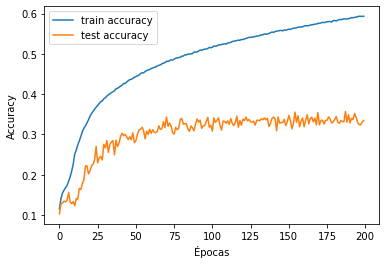

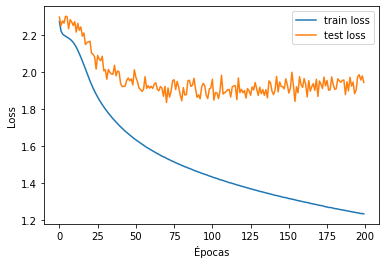

In [37]:
# ahora tengo los datos train_acc,train_loss,test_acc,test_loss
epocas = 200
e = range(epocas)
plt.figure(1)
#train_acc y test_acc en funcion de epocas
plt.plot(e,train_acc,label="train accuracy")
plt.plot(e,test_acc,label="test accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
#plt.savefig("ej4_epochacc.pdf")
#train_loss y test_loss en funcion de epocas
plt.figure(2)
plt.plot(e,train_loss,label="train loss")
plt.plot(e,test_loss,label="test loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("ej4_epochloss.pdf")

In [38]:
np.savetxt('ej4_accepochs.csv', (e,test_acc), delimiter=',')

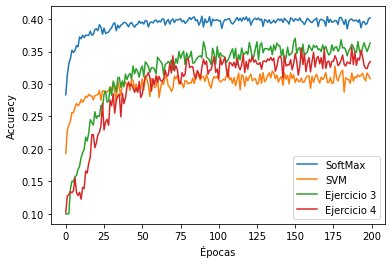

In [39]:
x_sftmax,y_sftmax = np.genfromtxt('linclass_cifar10_softmax.csv',delimiter=',')
x_svm,y_svm = np.genfromtxt('linclass_cifar10_svm.csv',delimiter=',')
x_ej3,y_ej3 = np.genfromtxt('ej3_accepochs.csv',delimiter=',')
plt.plot(x_sftmax,y_sftmax,label='SoftMax')
plt.plot(x_svm,y_svm,label='SVM')
plt.plot(x_ej3,y_ej3,label='Ejercicio 3')
plt.plot(e,test_acc,label='Ejercicio 4')
plt.plot()
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.savefig('ej4_comparacion.pdf')